In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time

from net.network import AttentionNet, Encoder, Decoder, SelfAttention
from net.utils import adaptive_instance_normalization
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_image', type=str, default='./datasets/test/content/lenna_cropped.jpg',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_image', type=str, default='./datasets/test/style/candy.jpg',
                    help='Directory path to a batch of style images')

parser.add_argument('--attn_model', type=str, default='models/content_wct/',
                    help='Directory path to a batch of style images')
parser.add_argument('--decoder_model', type=str, default='models/content_wct/',
                    help='Directory path to a batch of style images')

parser.add_argument('--save_dir', type=str, default='test_result/attention',
                    help='Directory path to a batch of style images')
# parser.add_argument('--model', type=str, default='models/content/',
#                     help='Directory path to a batch of style images')
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

cuda


torch.Size([3, 800, 800])


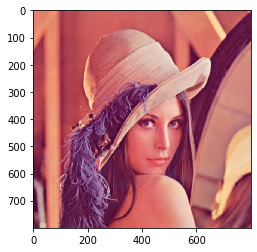

In [4]:
# loading test data

def test_transform():
    transform = transforms.Compose([
        transforms.Resize(size=(800, 800)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform
def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform
content_tf = test_transform()
content_tf_inv = test_transform_inv()
content = content_tf(Image.open(args.content_image).convert('RGB'))
print(content.shape)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(content_tf_inv(content)))

In [5]:
decoder = Decoder()
decoder.load_state_dict(torch.load(args.decoder_model + 'decoder_iter_80000.pth'))
attn = SelfAttention()
attn.load_state_dict(torch.load(args.attn_model + 'attention_kernel_iter_80000.pth'))
    
state_dict = decoder.state_dict()
for key in state_dict.keys():
    state_dict[key] = state_dict[key].to(device)
state_dict = attn.state_dict()
for key in state_dict.keys():
    state_dict[key] = state_dict[key].to(device)
    
model = AttentionNet(seperate=False, attn=attn, decoder=decoder)
model.cuda()
# optimizer = get_optimizer(model, args.seperate)
# optimizer.load_state_dict(torch.load(args.save_dir + 'optimizer_iter_' + str(args.start_iter) + '.pth'))
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

AttentionNet(
  (encode): Encoder()
  (self_attn): SelfAttention(
    (f): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (g): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (h): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (decode): Decoder(
    (deconv_4): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU()
      (7): ReflectionPad2d((1, 1, 1, 1))
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
      (10): ReflectionPad2d((1, 1, 1, 1))
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU()
    )
    (deconv_3): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 128, kernel_size=(3, 3), s

In [6]:
content = torch.stack([content], dim = 0)
content = content.to(device)

In [7]:
loss, content_result, attn_map = model(content)
print(loss)

{'total': tensor(20569.6953, device='cuda:0', grad_fn=<AddBackward0>), 'construct': tensor(387.2709, device='cuda:0', grad_fn=<MulBackward0>), 'percept': tensor(13576.5566, device='cuda:0', grad_fn=<MulBackward0>), 'tv': tensor(4.2596, device='cuda:0', grad_fn=<MulBackward0>), 'attn': tensor(512.9724, device='cuda:0', grad_fn=<NormBackward0>)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 800, 800])
torch.Size([3, 800, 800])


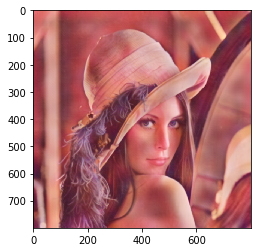

In [8]:
def imshow_recon(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
print(content_result[0].shape)
print(content[0].shape)
# content_result = adaptive_instance_normalization(content_result, content)
content_result = content_tf_inv(content_result[0])
imshow_recon(torchvision.utils.make_grid(content_result.cpu()))

torch.Size([1, 100, 100])


(-0.5, 99.5, 99.5, -0.5)

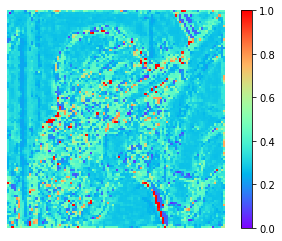

In [9]:
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())
plt.imshow(mean_sal_np[0], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')

In [10]:
print(attn_map.max())
print(attn_map.min())

tensor(0.0013, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0011, device='cuda:0', grad_fn=<MinBackward1>)


In [11]:
def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
def attention_filter(attention_feature_map, kernel_size=3, mean=6, stddev=5):
    attention_map = torch.abs(attention_feature_map)
    
    attention_mask = attention_map > 2 * torch.mean(attention_map)
    attention_mask = attention_mask.float()
    print(attention_mask.shape)
    
    w = torch.randn(kernel_size, kernel_size)
    truncated_normal_(w, mean, stddev)
    w = w / torch.sum(w)
    
    # [in_channels, out_channels, filter_height, filter_width]
    w = torch.unsqueeze(w, 0)
    w = w.repeat(attention_mask.shape[1], 1, 1)
    
    w = torch.unsqueeze(w, 0)
    w = w.repeat(attention_mask.shape[1], 1, 1, 1)
    
    gaussian_filter = nn.Conv2d(attention_mask.shape[1], attention_mask.shape[1], (kernel_size, kernel_size))
    gaussian_filter.weight.data = w
    gaussian_filter.weight.requires_grad = False
    pad_filter = nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        gaussian_filter
    )
    pad_filter.cuda()
    attention_map = pad_filter(attention_mask)
    attention_map = attention_map - torch.min(attention_map)
    attention_map = attention_map / torch.max(attention_map)
    return attention_map

torch.Size([1, 512, 100, 100])
torch.Size([1, 100, 100])


(-0.5, 99.5, 99.5, -0.5)

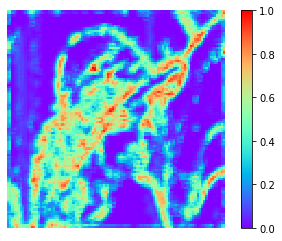

In [12]:
attn_map = attention_filter(attn_map)
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())

plt.imshow(mean_sal_np[0], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')
# plt.savefig(args.save_dir + '/puluowangsi_' + 'attn_style_decoder_style_attn.png')

In [13]:
print(attn_map.max())
print(attn_map.min())

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
